## SSAC - Exploration 4 - Sentiment Analysis : Naver Movie Review

In [1]:
# impore required packages
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
import re, os, gensim, random
from konlpy.tag import Okt
from konlpy.tag import Mecab
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
from gensim.models.keyedvectors import Word2VecKeyedVectors

In [2]:
# load data
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

print(train_data.shape, test_data.shape)
train_data.head()

(150000, 3) (50000, 3)


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [3]:
# stopwords
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','더이다','으실','.','을려고',
             '으로','자','에','와','한','하다','흠','아','들이','랍니다','세용','습니까','%','30']

In [4]:
# load morphological analyzer Mecab
tokenizer = Mecab()

In [5]:
vocab_size = 10000 # number of words

def load_data(train_data, test_data, num_words=vocab_size):

    train_data.drop_duplicates(subset=['document'], inplace=True) # remove duplicated review data
    train_data = train_data.dropna(how = 'any')  # remove 'NA'
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # tokenize using morphological analyzer
        temp_X = [word for word in temp_X if not word in stopwords] # remove stopwords
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # tokenize
        temp_X = [word for word in temp_X if not word in stopwords] # remove stopwords
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(vocab_size-4) # select most frequently used words 
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter] # add <pad>, <bos>, <unk>, <unused> to constructed vocab data
    word_to_index = {word:index for index, word in enumerate(vocab)} # make dictionary : word as key and index as value for encode

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist] 

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [6]:
temp = list(word_to_index.keys())

In [7]:
random.sample(temp, 12)

['어울렸', '놀라웠', '재일', '소릴', '444', '맥주', '끌려서', '일기', '에이즈', '불릴', '원생', '주몽']

## preprocess data

In [8]:
# make vice versa dictionary of 'word_to_index' for decode
index_to_word = {index:word for word, index in word_to_index.items()}

In [9]:
# define preprocess functions

# convert words in sentence to index
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# take list of sentences and return index list vector 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# decode encoded sentence 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# decode encoded sentences 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [10]:
# defined functions practice run
print(X_train[33])
print(get_decoded_sentence(X_train[33], index_to_word))
print('라벨: ', y_train[33])

[63, 370, 130, 38, 58, 53, 9417, 131, 9417, 131, 68]
라도 기대 했 던 내 죄인 입니다 죄인 입니다 ...
라벨:  0


In [11]:
# data exploration to determine max length of a sentence in dataset
total_data_text = list(X_train) + list(X_test)

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  14.81229042843467
문장길이 최대 :  115
문장길이 표준편차 :  12.063028090717818


In [12]:
# determine max length of sentences 
max_tokens = np.mean(num_tokens) + 2.5 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  44
전체 문장의 0.9521088978647377%가 maxlen 설정값 이내에 포함됩니다. 


In [13]:
# pre-padding
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

## split train dataset : validation and train

In [14]:
# examine shape of dataset
print(X_train.shape)
print(X_test.shape)

(146182, 44)
(49157, 44)


In [15]:
# set aside validation dataset : sligthly less than 20% of training data
x_val = X_train[:20000]   
y_val = y_train[:20000]

# make the rest train dataset
partial_x_train = X_train[20000:]  
partial_y_train = y_train[20000:]

print(partial_x_train.shape)
print(partial_y_train.shape)
print(x_val.shape)
print(y_val.shape)

(126182, 44)
(126182,)
(20000, 44)
(20000,)


+ Since the given training data is not 'big', I assumed assigning more data to train dataset would be better in model performance than having 20% of train data set as validation set.

## build model no.1 and train : RNN model

In [16]:
# build a model
word_vector_dim = 8

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 8)           80000     
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 544       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 80,625
Trainable params: 80,625
Non-trainable params: 0
_________________________________________________________________


In [17]:
# train a model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 20  

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
247/247 [==============================] - 1s 6ms/step - loss: 0.5089 - accuracy: 0.7792 - val_loss: 0.3684 - val_accuracy: 0.8428
Epoch 2/20
247/247 [==============================] - 1s 5ms/step - loss: 0.3447 - accuracy: 0.8553 - val_loss: 0.3471 - val_accuracy: 0.8510
Epoch 3/20
247/247 [==============================] - 1s 5ms/step - loss: 0.3204 - accuracy: 0.8654 - val_loss: 0.3447 - val_accuracy: 0.8504
Epoch 4/20
247/247 [==============================] - 1s 5ms/step - loss: 0.3098 - accuracy: 0.8713 - val_loss: 0.3469 - val_accuracy: 0.8515
Epoch 5/20
247/247 [==============================] - 1s 5ms/step - loss: 0.3014 - accuracy: 0.8751 - val_loss: 0.3488 - val_accuracy: 0.8518
Epoch 6/20
247/247 [==============================] - 1s 5ms/step - loss: 0.2951 - accuracy: 0.8784 - val_loss: 0.3572 - val_accuracy: 0.8479
Epoch 7/20
247/247 [==============================] - 1s 5ms/step - loss: 0.2893 - accuracy: 0.8811 - val_loss: 0.3542 - val_accuracy: 0.8503
Epoch 

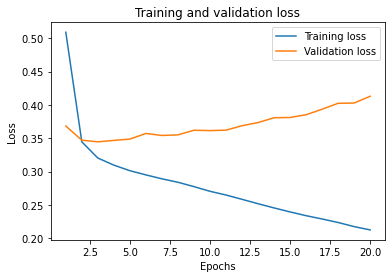

In [18]:
# loss graph in train and validation set
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

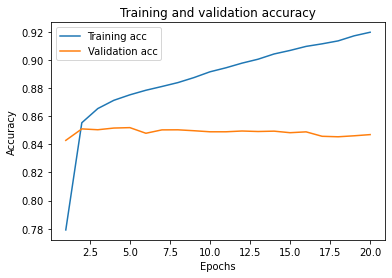

In [19]:
# accuracy graph in train and validation set
plt.clf()

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

+ validation loss fluctuates around epochs 4 and 5 then starts to increases making gap between training loss and validation loss
+ accuracy shows similar graph; gap widens after 4.

In [20]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 8)           80000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 544       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 80,625
Trainable params: 80,625
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 4  

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/4
247/247 [==============================] - 1s 6ms/step - loss: 0.5267 - accuracy: 0.7549 - val_loss: 0.3790 - val_accuracy: 0.8362
Epoch 2/4
247/247 [==============================] - 1s 5ms/step - loss: 0.3475 - accuracy: 0.8534 - val_loss: 0.3504 - val_accuracy: 0.8472
Epoch 3/4
247/247 [==============================] - 1s 5ms/step - loss: 0.3193 - accuracy: 0.8675 - val_loss: 0.3464 - val_accuracy: 0.8533
Epoch 4/4
247/247 [==============================] - 1s 5ms/step - loss: 0.3068 - accuracy: 0.8733 - val_loss: 0.3469 - val_accuracy: 0.8537


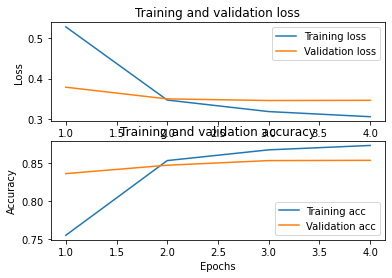

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.subplot(2,1,1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2,1,2)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [23]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3558 - accuracy: 0.8469
[0.35576295852661133, 0.8468783497810364]


+ trained model with lstm layer achieves 84.6% accuracy with test dataset

In [24]:
# save trained embedding parameters 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_lstm.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [25]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['기대']
vector

array([ 0.00637732,  0.07051526, -0.07803115, -0.01788745,  0.00741166,
       -0.04852904,  0.11119606, -0.02652132], dtype=float32)

In [26]:
word_vectors.similar_by_word("기대")

[('널', 0.9567669034004211),
 ('순위', 0.9493257999420166),
 ('정려원', 0.9410772323608398),
 ('꾼', 0.9290734529495239),
 ('싱', 0.9265799522399902),
 ('주', 0.9172757863998413),
 ('고스트', 0.9171186685562134),
 ('@', 0.9134852886199951),
 ('잠깐', 0.9069699645042419),
 ('비평', 0.8998109102249146)]

+ despite high accuracy in test set, word embedding seems random to me. I find it hard to collocate or connect seleted words by a model with given word '기대'.

## build model no.2 and train : 1d-convolution layer

In [27]:
# bulid a model
word_vector_dim = 8

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 8, activation='relu'))
model.add(keras.layers.MaxPooling1D(4))
model.add(keras.layers.Conv1D(16, 8, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 8)           80000     
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1040      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          2064      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [28]:
# train a model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 20  

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
247/247 [==============================] - 7s 29ms/step - loss: 0.5423 - accuracy: 0.7160 - val_loss: 0.3808 - val_accuracy: 0.8315
Epoch 2/20
247/247 [==============================] - 1s 4ms/step - loss: 0.3548 - accuracy: 0.8454 - val_loss: 0.3612 - val_accuracy: 0.8393
Epoch 3/20
247/247 [==============================] - 1s 4ms/step - loss: 0.3235 - accuracy: 0.8611 - val_loss: 0.3584 - val_accuracy: 0.8429
Epoch 4/20
247/247 [==============================] - 1s 4ms/step - loss: 0.3023 - accuracy: 0.8728 - val_loss: 0.3618 - val_accuracy: 0.8431
Epoch 5/20
247/247 [==============================] - 1s 4ms/step - loss: 0.2821 - accuracy: 0.8836 - val_loss: 0.3643 - val_accuracy: 0.8439
Epoch 6/20
247/247 [==============================] - 1s 4ms/step - loss: 0.2631 - accuracy: 0.8940 - val_loss: 0.3771 - val_accuracy: 0.8428
Epoch 7/20
247/247 [==============================] - 1s 4ms/step - loss: 0.2443 - accuracy: 0.9024 - val_loss: 0.3899 - val_accuracy: 0.8396
Epoch

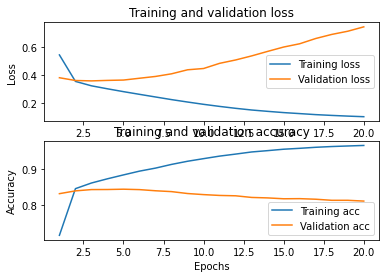

In [29]:
# loss and accuracy graph
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.subplot(2,1,1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2,1,2)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

+ this model shows similar loss and accuracy graph to previous lstm model; gap widens after 4 to 5 epochs.

In [30]:
# re-build a model
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 8, activation='relu'))
model.add(keras.layers.MaxPooling1D(4))
model.add(keras.layers.Conv1D(16, 8, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 8)           80000     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 16)          1040      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 16)          2064      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [31]:
# train model with less epoch
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 3

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/3
247/247 [==============================] - 1s 4ms/step - loss: 0.5478 - accuracy: 0.7035 - val_loss: 0.3839 - val_accuracy: 0.8285
Epoch 2/3
247/247 [==============================] - 1s 4ms/step - loss: 0.3543 - accuracy: 0.8456 - val_loss: 0.3668 - val_accuracy: 0.8385
Epoch 3/3
247/247 [==============================] - 1s 4ms/step - loss: 0.3207 - accuracy: 0.8621 - val_loss: 0.3582 - val_accuracy: 0.8413


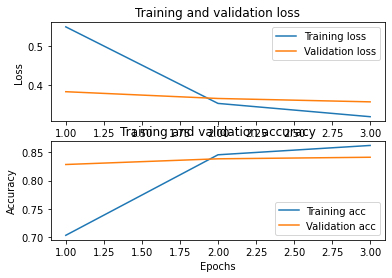

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.subplot(2,1,1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2,1,2)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [33]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3666 - accuracy: 0.8381
[0.36656901240348816, 0.8381105661392212]


+ achieved rather low accuracy.
   + I wonder what makes difference between lstm and conv1d. 

In [37]:
# save trained embedding parameters 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_conv1d.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  

vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [38]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['기대']
vector

array([ 0.00483618, -0.06186387,  0.02619092,  0.02856239,  0.06228601,
        0.13126233,  0.01655151, -0.08023886], dtype=float32)

In [39]:
word_vectors.similar_by_word("기대")

[('어딘가', 0.8945257067680359),
 ('절실', 0.8726669549942017),
 ('전', 0.8672779202461243),
 ('한테', 0.8581224679946899),
 ('된다는', 0.8564485907554626),
 ('특색', 0.8529115915298462),
 ('사마', 0.8526506423950195),
 ('공영', 0.8486758470535278),
 ('.................', 0.8419909477233887),
 ('애새끼', 0.8402138352394104)]

+ Neither this model gives convincing similar words.

---

## build model no.3 and train : global max pooling layer

In [40]:
word_vector_dim = 8   

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 8)           80000     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 8)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 80,081
Trainable params: 80,081
Non-trainable params: 0
_________________________________________________________________


In [41]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 10   

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
247/247 [==============================] - 1s 3ms/step - loss: 0.6440 - accuracy: 0.7236 - val_loss: 0.5337 - val_accuracy: 0.7843
Epoch 2/10
247/247 [==============================] - 1s 3ms/step - loss: 0.4382 - accuracy: 0.8164 - val_loss: 0.3933 - val_accuracy: 0.8248
Epoch 3/10
247/247 [==============================] - 1s 3ms/step - loss: 0.3633 - accuracy: 0.8445 - val_loss: 0.3714 - val_accuracy: 0.8353
Epoch 4/10
247/247 [==============================] - 1s 4ms/step - loss: 0.3353 - accuracy: 0.8574 - val_loss: 0.3650 - val_accuracy: 0.8381
Epoch 5/10
247/247 [==============================] - 1s 3ms/step - loss: 0.3170 - accuracy: 0.8668 - val_loss: 0.3639 - val_accuracy: 0.8392
Epoch 6/10
247/247 [==============================] - 1s 3ms/step - loss: 0.3036 - accuracy: 0.8732 - val_loss: 0.3658 - val_accuracy: 0.8411
Epoch 7/10
247/247 [==============================] - 1s 3ms/step - loss: 0.2927 - accuracy: 0.8782 - val_loss: 0.3686 - val_accuracy: 0.8411
Epoch 

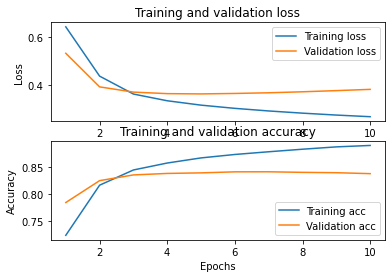

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.subplot(2,1,1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2,1,2)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

+ this model shows similar loss and accuracy graph to previous lstm models as well.
  + maybe task is rather simple to models. : It is binary classification after all.

In [43]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 8)           80000     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 8)                 0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 80,081
Trainable params: 80,081
Non-trainable params: 0
_________________________________________________________________


In [44]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 5  

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
247/247 [==============================] - 1s 3ms/step - loss: 0.6127 - accuracy: 0.7205 - val_loss: 0.4923 - val_accuracy: 0.8033
Epoch 2/5
247/247 [==============================] - 1s 3ms/step - loss: 0.4243 - accuracy: 0.8218 - val_loss: 0.3918 - val_accuracy: 0.8303
Epoch 3/5
247/247 [==============================] - 1s 3ms/step - loss: 0.3594 - accuracy: 0.8461 - val_loss: 0.3709 - val_accuracy: 0.8364
Epoch 4/5
247/247 [==============================] - 1s 3ms/step - loss: 0.3305 - accuracy: 0.8598 - val_loss: 0.3654 - val_accuracy: 0.8396
Epoch 5/5
247/247 [==============================] - 1s 3ms/step - loss: 0.3121 - accuracy: 0.8685 - val_loss: 0.3663 - val_accuracy: 0.8409


In [45]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 1s - loss: 0.3722 - accuracy: 0.8379
[0.3721981644630432, 0.8379071354866028]


+ surprisingly, it achieved similar accuracy to more complicated conv1d model.
  + still. lower than lstm.

In [46]:
# save trained embedding parameters
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_maxpool.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim)) 


vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [47]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['기대']
vector

array([-0.10612258, -0.06031119, -0.07012986, -0.00012586, -0.04432099,
       -0.111586  , -0.10644019, -0.03575396], dtype=float32)

In [48]:
word_vectors.similar_by_word("기대")

[('드래곤볼', 0.9856970310211182),
 ('막상', 0.9809916019439697),
 ('라면', 0.9773523807525635),
 ('애기', 0.9748612642288208),
 ('요새', 0.9747428894042969),
 ('로맨틱', 0.9746811389923096),
 ('반', 0.973720133304596),
 ('시청자', 0.9734678268432617),
 ('대사', 0.9716449975967407),
 ('영어', 0.9715708494186401)]

+ Not sure of similarity of the selected words

## build model no.4 and train : lstm after conv1d

+ lstm model shows best results among above three models. 
  + could feeding features filtered by conv1d layer to lstm make better result?

In [49]:
word_vector_dim = 8    

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 8, activation='relu'))
model.add(keras.layers.LSTM(16))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 8)           80000     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 16)          1040      
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 83,297
Trainable params: 83,297
Non-trainable params: 0
_________________________________________________________________


In [50]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 10

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
247/247 [==============================] - 2s 6ms/step - loss: 0.5424 - accuracy: 0.7473 - val_loss: 0.3993 - val_accuracy: 0.8332
Epoch 2/10
247/247 [==============================] - 1s 5ms/step - loss: 0.3483 - accuracy: 0.8531 - val_loss: 0.3465 - val_accuracy: 0.8496
Epoch 3/10
247/247 [==============================] - 1s 5ms/step - loss: 0.3115 - accuracy: 0.8697 - val_loss: 0.3389 - val_accuracy: 0.8533
Epoch 4/10
247/247 [==============================] - 1s 5ms/step - loss: 0.2901 - accuracy: 0.8807 - val_loss: 0.3385 - val_accuracy: 0.8537
Epoch 5/10
247/247 [==============================] - 1s 5ms/step - loss: 0.2717 - accuracy: 0.8906 - val_loss: 0.3381 - val_accuracy: 0.8549
Epoch 6/10
247/247 [==============================] - 1s 5ms/step - loss: 0.2541 - accuracy: 0.8986 - val_loss: 0.3426 - val_accuracy: 0.8547
Epoch 7/10
247/247 [==============================] - 1s 5ms/step - loss: 0.2366 - accuracy: 0.9067 - val_loss: 0.3576 - val_accuracy: 0.8539
Epoch 

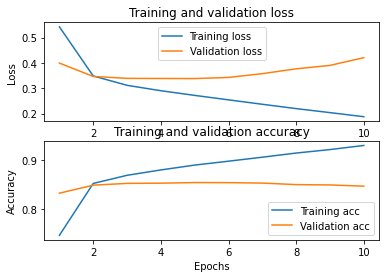

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.subplot(2,1,1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2,1,2)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

+ this model also shows fluctuating validation loss after 4 to 5 epochs.

In [56]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 8, activation='relu'))
model.add(keras.layers.LSTM(16))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 8)           80000     
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 16)          1040      
_________________________________________________________________
lstm_4 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 9         
Total params: 83,297
Trainable params: 83,297
Non-trainable params: 0
_________________________________________________________________


In [57]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 4

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/4
247/247 [==============================] - 2s 6ms/step - loss: 0.4844 - accuracy: 0.7640 - val_loss: 0.3609 - val_accuracy: 0.8425
Epoch 2/4
247/247 [==============================] - 1s 5ms/step - loss: 0.3316 - accuracy: 0.8584 - val_loss: 0.3433 - val_accuracy: 0.8508
Epoch 3/4
247/247 [==============================] - 1s 5ms/step - loss: 0.3048 - accuracy: 0.8716 - val_loss: 0.3400 - val_accuracy: 0.8546
Epoch 4/4
247/247 [==============================] - 1s 5ms/step - loss: 0.2861 - accuracy: 0.8820 - val_loss: 0.3401 - val_accuracy: 0.8554


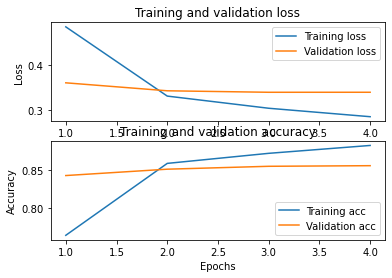

In [58]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.subplot(2,1,1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2,1,2)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [59]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3475 - accuracy: 0.8489
[0.34753212332725525, 0.8489126563072205]


+ slightly better than single lstm layer

In [60]:
# save trained embedding parameters
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_conv1d_lstm.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim)) 


vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [61]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['기대']
vector

array([ 0.03267838,  0.03305706, -0.07707328, -0.05503474,  0.02648693,
        0.00805383, -0.00176919,  0.0904199 ], dtype=float32)

In [62]:
word_vectors.similar_by_word("기대")

[('임청하', 0.9665480256080627),
 ('빈다', 0.9629472494125366),
 ('일으키', 0.9603288173675537),
 ('으니깐', 0.9599167108535767),
 ('패션', 0.933426022529602),
 ('욧', 0.9300893545150757),
 ('닉쿤', 0.9287704825401306),
 ('a', 0.9253720045089722),
 ('다람쥐', 0.9238836765289307),
 ('국', 0.9237772822380066)]

+ it seems completely ramdom selection.

---

## use pre-trained word2vec embedding to improve model performance

In [63]:
path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko/ko.bin'
trained_w2v = gensim.models.Word2Vec.load(path)

In [64]:
similar_vec = trained_w2v.wv.most_similar("기대")
similar_vec

[('예상', 0.5993404388427734),
 ('예측', 0.5521305203437805),
 ('전망', 0.5395902395248413),
 ('걱정', 0.5109213590621948),
 ('우려', 0.5100494623184204),
 ('생각', 0.5072912573814392),
 ('평가', 0.5036546587944031),
 ('신뢰', 0.5025410652160645),
 ('희망', 0.49611741304397583),
 ('관심도', 0.4947463572025299)]

+ pre-trained word2vec embedding gives convincing set of similar words.

In [65]:
type(trained_w2v)

gensim.models.word2vec.Word2Vec

In [66]:
type(word_vectors)

gensim.models.keyedvectors.Word2VecKeyedVectors

In [67]:
trained_word_vectors = trained_w2v.wv

In [68]:
type(trained_word_vectors)

gensim.models.keyedvectors.Word2VecKeyedVectors

In [69]:
vector = trained_word_vectors['기대']
print(vector.shape)
vector

(200,)


array([-0.42679408,  0.5892111 ,  0.6219986 , -2.321125  , -1.4077828 ,
        2.0710788 , -1.202137  , -0.11560407, -1.9535756 , -0.33151925,
       -0.94134295, -1.3920565 , -0.673567  , -0.7687422 ,  0.7271645 ,
       -0.8008593 , -0.43518832, -0.9391257 , -1.9923116 , -0.4860049 ,
        2.0586452 ,  0.08421105, -0.86913145,  1.288601  ,  1.433492  ,
        1.2044291 , -0.54404306, -1.5097954 , -0.52747834, -0.74069464,
       -1.4989316 ,  0.70926476, -1.7328253 , -1.3000728 ,  0.810795  ,
       -0.6369874 ,  1.7686176 , -0.6763047 , -0.5367612 ,  2.4611883 ,
        1.4960446 , -0.1725292 , -0.45655453,  0.2681983 ,  0.3066007 ,
        0.30748022,  2.2485256 , -0.8582102 ,  0.39929923,  0.00466653,
        0.3073698 ,  0.85514444, -0.5583773 ,  1.4897436 , -0.805984  ,
       -0.7717855 ,  1.499113  , -0.51766735, -0.5974332 ,  0.85677636,
       -0.74764436,  2.067837  , -0.740197  ,  0.29757446, -1.7932417 ,
        0.57957464,  0.05866075,  1.2170862 ,  1.7554603 ,  0.86

In [70]:
trained_word_vectors.similar_by_word("기대")

[('예상', 0.5993404388427734),
 ('예측', 0.5521305203437805),
 ('전망', 0.5395902395248413),
 ('걱정', 0.5109213590621948),
 ('우려', 0.5100494623184204),
 ('생각', 0.5072912573814392),
 ('평가', 0.5036546587944031),
 ('신뢰', 0.5025410652160645),
 ('희망', 0.49611741304397583),
 ('관심도', 0.4947463572025299)]

In [71]:
vocab_size = 10000    
word_vector_dim = 200  # pre-trained word2vec dimension

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# copy pretrained embedding to embedding_matrix
for i in range(4,vocab_size):
    if index_to_word[i] in trained_word_vectors:
        embedding_matrix[i] = trained_word_vectors[index_to_word[i]]

In [72]:
embedding_matrix.shape

(10000, 200)

In [73]:
from tensorflow.keras.initializers import Constant

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  
                                 input_length=maxlen, 
                                 trainable=True))   
model.add(keras.layers.Conv1D(16, 8, activation='relu'))
model.add(keras.layers.LSTM(16))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 44, 200)           2000000   
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 37, 16)            25616     
_________________________________________________________________
lstm_5 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense_18 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 9         
Total params: 2,027,873
Trainable params: 2,027,873
Non-trainable params: 0
_________________________________________________________________


In [74]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 10 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
247/247 [==============================] - 11s 44ms/step - loss: 0.5008 - accuracy: 0.7519 - val_loss: 0.3990 - val_accuracy: 0.8188
Epoch 2/10
247/247 [==============================] - 7s 27ms/step - loss: 0.3613 - accuracy: 0.8433 - val_loss: 0.3571 - val_accuracy: 0.8454
Epoch 3/10
247/247 [==============================] - 7s 26ms/step - loss: 0.3137 - accuracy: 0.8673 - val_loss: 0.3409 - val_accuracy: 0.8514
Epoch 4/10
247/247 [==============================] - 7s 27ms/step - loss: 0.2835 - accuracy: 0.8819 - val_loss: 0.3343 - val_accuracy: 0.8570
Epoch 5/10
247/247 [==============================] - 7s 26ms/step - loss: 0.2604 - accuracy: 0.8935 - val_loss: 0.3388 - val_accuracy: 0.8555
Epoch 6/10
247/247 [==============================] - 7s 27ms/step - loss: 0.2398 - accuracy: 0.9034 - val_loss: 0.3450 - val_accuracy: 0.8559
Epoch 7/10
247/247 [==============================] - 7s 27ms/step - loss: 0.2213 - accuracy: 0.9121 - val_loss: 0.3612 - val_accuracy: 0.854

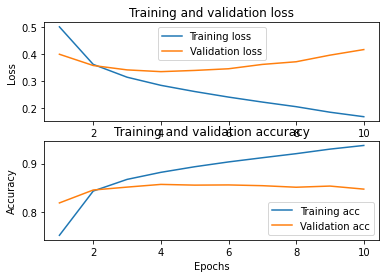

In [75]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.subplot(2,1,1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2,1,2)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

+ As the model starts from the pre-trained word vectors validation loss of first epoch shows rather low than previous models.
  + still after 4 to 5 epochs loss and accuarcy of validation set fluctuates.

In [76]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  
                                 input_length=maxlen, 
                                 trainable=True))   
model.add(keras.layers.Conv1D(16, 8, activation='relu'))
model.add(keras.layers.LSTM(16))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 44, 200)           2000000   
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 37, 16)            25616     
_________________________________________________________________
lstm_6 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense_20 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 9         
Total params: 2,027,873
Trainable params: 2,027,873
Non-trainable params: 0
_________________________________________________________________


In [77]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 4

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/4
247/247 [==============================] - 7s 28ms/step - loss: 0.5035 - accuracy: 0.7532 - val_loss: 0.4042 - val_accuracy: 0.8173
Epoch 2/4
247/247 [==============================] - 7s 27ms/step - loss: 0.3617 - accuracy: 0.8427 - val_loss: 0.3480 - val_accuracy: 0.8462
Epoch 3/4
247/247 [==============================] - 7s 27ms/step - loss: 0.3119 - accuracy: 0.8682 - val_loss: 0.3365 - val_accuracy: 0.8522
Epoch 4/4
247/247 [==============================] - 7s 26ms/step - loss: 0.2806 - accuracy: 0.8833 - val_loss: 0.3362 - val_accuracy: 0.8548


In [78]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.3450 - accuracy: 0.8517
[0.3449532091617584, 0.8516589999198914]


+ achieved test set accuracy higher than criteria of 85%.
+ using pre-trained word2vec embedding surely improves model performace

In [79]:
# save trained embedding parameters
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_using_pretrained.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim)) 


vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [80]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
word_vectors.similar_by_word("기대")

[('예상', 0.5944077372550964),
 ('예측', 0.5475966930389404),
 ('생각', 0.5030966401100159),
 ('평가', 0.5023589730262756),
 ('걱정', 0.500863254070282),
 ('우려', 0.49931639432907104),
 ('신뢰', 0.497389554977417),
 ('희망', 0.49605628848075867),
 ('확신', 0.48346441984176636),
 ('욕구', 0.4833561182022095)]

+ it is hard to say they are synonyms but I can easilty associate selected words with '기대'.

## Thoughts

+ publishing pre-trained word embedding will help other nlp projects.
   + shame googling pre-trained korean embedding all direct to one repository.

---